In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [2]:
customers_df = pd.read_csv('Customers.csv')
transactions_df = pd.read_csv('Transactions.csv')

In [3]:
def create_customer_features(customers_df, transactions_df):
    # Calculate days since signup
    customers_df['SignupDate'] = pd.to_datetime(customers_df['SignupDate'])
    customers_df['days_since_signup'] = (datetime.now() - customers_df['SignupDate']).dt.days
    
    # Calculate transaction-based features per customer
    transaction_features = transactions_df.groupby('CustomerID').agg({
        'TransactionID': 'count',  # Number of transactions
        'TotalValue': ['sum', 'mean', 'std'],  # Purchase behavior
        'Quantity': ['sum', 'mean', 'std']  # Purchase quantity behavior
    }).fillna(0)
    
    # Flatten column names
    transaction_features.columns = ['_'.join(col).strip() for col in transaction_features.columns.values]
    
    # Calculate recency
    transactions_df['TransactionDate'] = pd.to_datetime(transactions_df['TransactionDate'])
    latest_date = transactions_df['TransactionDate'].max()
    
    recency = transactions_df.groupby('CustomerID')['TransactionDate'].max()
    recency = (latest_date - recency).dt.days
    
    # Merge all features
    features_df = customers_df[['CustomerID', 'days_since_signup']].merge(
        transaction_features, 
        left_on='CustomerID', 
        right_index=True,
        how='left'
    )
    
    features_df = features_df.merge(
        pd.DataFrame(recency, columns=['recency']),
        left_on='CustomerID',
        right_index=True,
        how='left'
    )
    
    return features_df.fillna(0)

# Create feature matrix
features_df = create_customer_features(customers_df, transactions_df)
print("\nFeatures created. Shape of feature matrix:", features_df.shape)
display(features_df.head())

# Select features for clustering
feature_columns = [col for col in features_df.columns if col != 'CustomerID']
print("\nFeatures used for clustering:", feature_columns)

# Scale the features
print("\nScaling features...")
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features_df[feature_columns])


Features created. Shape of feature matrix: (200, 10)


C:\Users\nitya\AppData\Local\Temp\ipykernel_21592\3211684780.py:38: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  return features_df.fillna(0)


,CustomerID,days_since_signup,TransactionID_count,TotalValue_sum,TotalValue_mean,TotalValue_std,Quantity_sum,Quantity_mean,Quantity_std,recency
0,C0001,932,5.0,3354.52,670.904,456.643861,12.0,2.400000,0.547723,0
1,C0002,1079,4.0,1862.74,465.685,219.519169,10.0,2.500000,1.000000,0
2,C0003,326,4.0,2725.38,681.345,559.276543,14.0,3.500000,0.577350,0
3,C0004,841,8.0,5354.88,669.360,325.386829,23.0,2.875000,1.125992,0
4,C0005,896,3.0,2034.24,678.080,310.820746,7.0,2.333333,0.577350,0



Features used for clustering: ['days_since_signup', 'TransactionID_count', 'TotalValue_sum', 'TotalValue_mean', 'TotalValue_std', 'Quantity_sum', 'Quantity_mean', 'Quantity_std', 'recency']

Scaling features...


In [4]:
def evaluate_clusters(scaled_features, max_clusters=10):
    print(f"\nEvaluating clusters from 2 to {max_clusters}...")
    db_scores = []
    inertias = []
    
    for n_clusters in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        cluster_labels = kmeans.fit_predict(scaled_features)
        
        db_score = davies_bouldin_score(scaled_features, cluster_labels)
        db_scores.append(db_score)
        inertias.append(kmeans.inertia_)
        
        print(f"Clusters: {n_clusters}, Davies-Bouldin Score: {db_score:.4f}")
        
    return db_scores, inertias


Evaluating clusters from 2 to 10...
Clusters: 2, Davies-Bouldin Score: 1.4580
Clusters: 3, Davies-Bouldin Score: 1.4442
Clusters: 4, Davies-Bouldin Score: 1.6017
Clusters: 5, Davies-Bouldin Score: 1.4934
Clusters: 6, Davies-Bouldin Score: 1.4188
Clusters: 7, Davies-Bouldin Score: 1.3669
Clusters: 8, Davies-Bouldin Score: 1.4676
Clusters: 9, Davies-Bouldin Score: 1.4259
Clusters: 10, Davies-Bouldin Score: 1.3939

Optimal number of clusters based on Davies-Bouldin Index: 7


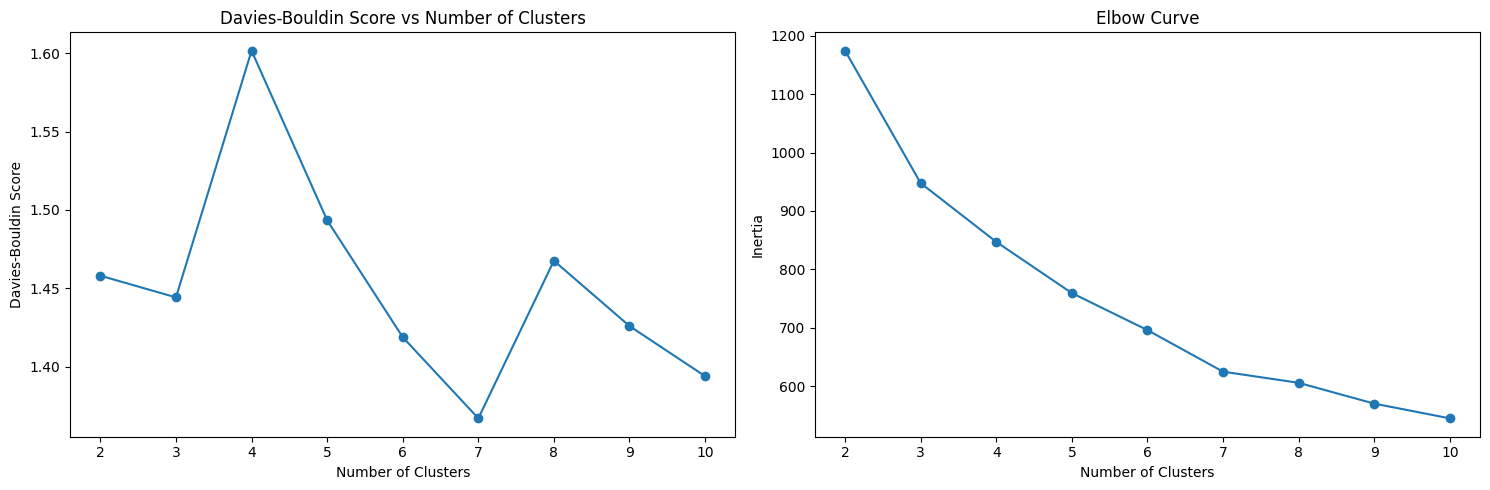


Fitting final clustering model...

Calculating cluster metrics...

Cluster Metrics:


,TransactionID_count,TotalValue_sum,Quantity_sum,recency,CustomerID
Cluster,,,,,
0,7.92,6094.58,21.49,0.0,39
1,4.40,3251.23,10.80,0.0,35
2,3.86,2387.71,9.60,0.0,42
3,2.00,568.81,3.13,0.0,15
4,4.71,4572.01,15.21,0.0,24
5,6.18,2987.36,12.85,0.0,34
6,2.00,1672.66,6.27,0.0,11


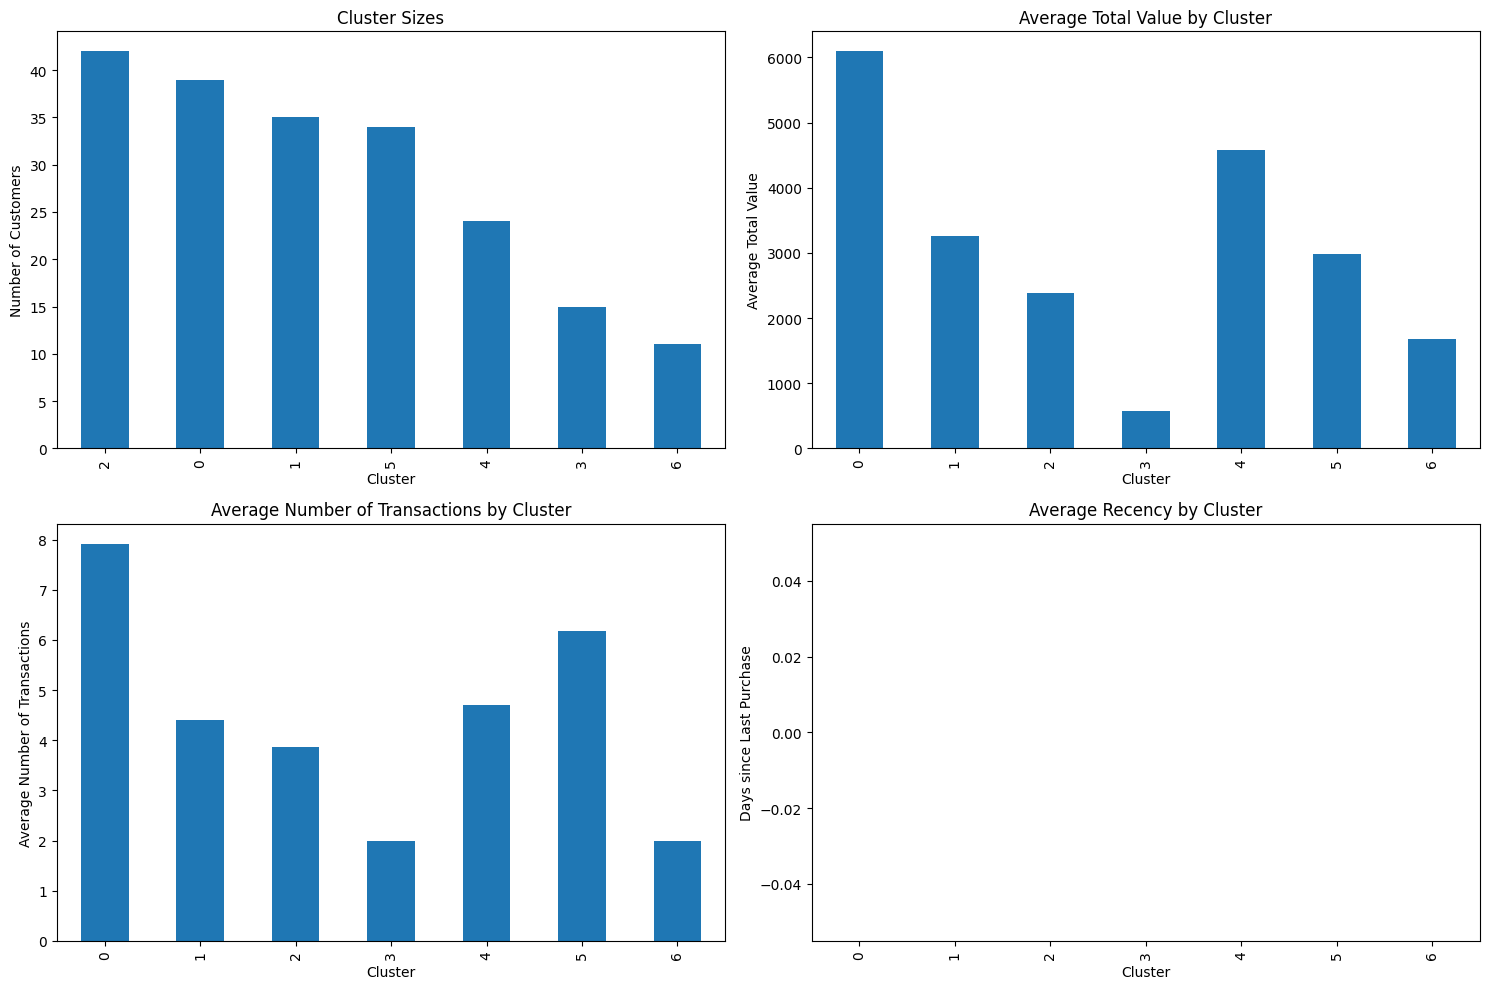


Results saved to Nityam_Nityam_Clustering.csv

Clustering Summary:
Number of clusters: 7
Davies-Bouldin Index: 1.3669
Number of features used: 9
Total customers clustered: 200


In [5]:
db_scores, inertias = evaluate_clusters(scaled_features)

# Find optimal number of clusters
optimal_clusters = db_scores.index(min(db_scores)) + 2
print(f"\nOptimal number of clusters based on Davies-Bouldin Index: {optimal_clusters}")

# Visualize results
plt.figure(figsize=(15, 5))

# Plot 1: Davies-Bouldin scores
plt.subplot(1, 2, 1)
plt.plot(range(2, len(db_scores) + 2), db_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Davies-Bouldin Score')
plt.title('Davies-Bouldin Score vs Number of Clusters')

# Plot 2: Elbow curve
plt.subplot(1, 2, 2)
plt.plot(range(2, len(inertias) + 2), inertias, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Curve')

plt.tight_layout()
plt.show()

# Fit final clustering model
print("\nFitting final clustering model...")
final_kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
cluster_labels = final_kmeans.fit_predict(scaled_features)

# Add cluster labels to the original dataframe
features_df['Cluster'] = cluster_labels

# Calculate cluster metrics
print("\nCalculating cluster metrics...")
cluster_metrics = features_df.groupby('Cluster').agg({
    'TransactionID_count': 'mean',
    'TotalValue_sum': 'mean',
    'Quantity_sum': 'mean',
    'recency': 'mean',
    'CustomerID': 'count'
}).round(2)

print("\nCluster Metrics:")
display(cluster_metrics)

# Visualize cluster characteristics
plt.figure(figsize=(15, 10))

# Plot cluster sizes
plt.subplot(2, 2, 1)
features_df['Cluster'].value_counts().plot(kind='bar')
plt.title('Cluster Sizes')
plt.xlabel('Cluster')
plt.ylabel('Number of Customers')

# Plot average transaction values
plt.subplot(2, 2, 2)
cluster_metrics['TotalValue_sum'].plot(kind='bar')
plt.title('Average Total Value by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Average Total Value')

# Plot average number of transactions
plt.subplot(2, 2, 3)
cluster_metrics['TransactionID_count'].plot(kind='bar')
plt.title('Average Number of Transactions by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Average Number of Transactions')

# Plot average recency
plt.subplot(2, 2, 4)
cluster_metrics['recency'].plot(kind='bar')
plt.title('Average Recency by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Days since Last Purchase')

plt.tight_layout()
plt.show()

# Save results
output_filename = 'Nityam_Nityam_Clustering.csv'
features_df[['CustomerID', 'Cluster']].to_csv(output_filename, index=False)
print(f"\nResults saved to {output_filename}")

# Print final summary
print("\nClustering Summary:")
print(f"Number of clusters: {optimal_clusters}")
print(f"Davies-Bouldin Index: {min(db_scores):.4f}")
print(f"Number of features used: {len(feature_columns)}")
print(f"Total customers clustered: {len(features_df)}")